## Librerías

In [75]:
!pip install shap

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import lightgbm as lgb
from scipy.stats import shapiro




from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from joblib import Parallel, delayed
from time import time
import duckdb
# %load_ext sql
# %config SqlMagic.autopandas = True
# %config SqlMagic.feedback = False
# %config SqlMagic.displaycon = False
# %sql duckdb:///:memory:
import time
import optuna
from optuna.study import MaxTrialsCallback
from optuna.trial import TrialState

from optuna.visualization import plot_param_importances, plot_contour,  plot_slice, plot_optimization_history
import plotly.express as px
import shap
import os

import kaggle 
import glob



In [77]:

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104
mes_test = 202106


# Experimento

In [78]:
data = pd.read_csv(r"c:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\datasets\competencia_2\competencia_02_ct.csv")

In [79]:
# import duckdb


# con = duckdb.connect(database=':memory:', read_only=False)
# df_parallel = pd.read_csv(r"c:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\datasets\competencia_2\competencia_02_crudo.csv")


# start_time = time.time()

# # Crear la columna clase_ternaria usando la columna 'foto_mes' basada en la presencia real

# df_ternaria= duckdb.query('''

#     WITH siguiente_mes AS (

#         SELECT

#             numero_de_cliente,

#             foto_mes,

#             -- Obtener los meses siguientes en los que el cliente está presente

#             LEAD(foto_mes, 1) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS foto_mes_proximo1,

#             LEAD(foto_mes, 2) OVER (PARTITION BY numero_de_cliente ORDER BY foto_mes) AS foto_mes_proximo2

#         FROM df_parallel

#     )

#     SELECT

#         numero_de_cliente,

#         foto_mes,

#         CASE

#             -- Si el cliente está en los dos meses consecutivos siguientes

#             WHEN foto_mes_proximo1 = foto_mes + 1 AND foto_mes_proximo2 = foto_mes + 2 THEN 'CONTINUA'

#             -- Si el cliente no está en el siguiente mes

#             WHEN foto_mes_proximo1 IS NULL OR foto_mes_proximo1 <> foto_mes + 1 THEN 'BAJA+1'

#             -- Si el cliente está en el siguiente mes pero no en el segundo mes consecutivo

#             WHEN foto_mes_proximo1 = foto_mes + 1 AND (foto_mes_proximo2 IS NULL OR foto_mes_proximo2 <> foto_mes + 2) THEN 'BAJA+2'

#             ELSE NULL

#         END AS clase_ternaria

#     FROM siguiente_mes

#     ORDER BY numero_de_cliente, foto_mes

#     ''')

# df_ternaria = df_ternaria.to_df()
# df_ternaria = df_ternaria[['numero_de_cliente', 'foto_mes', 'clase_ternaria']]


# df_parallel = df_parallel.merge(df_ternaria, on=['numero_de_cliente', 'foto_mes'], how='left')

# df_parallel.to_csv(r"c:\Users\Admin\Documents\1_Notebook\1_Estudio\1_UBA_Maestria_DS\1_Especializacion\1_Segundo_Semestre\DMEyF\datasets\competencia_2\competencia_02_ct.csv", index=False)




In [80]:
data['clase_peso'] = 1.0
data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [81]:
def lgb_gan_eval(y_pred, data):
    weight = data.get_weight()
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]]
    ganancia = np.cumsum(ganancia)

    return 'gan_eval', np.max(ganancia) , True

In [82]:
data['clase_binaria'] = np.where(data['clase_ternaria']=='CONTINUA', 0, 1)

In [83]:
data['foto_mes'].value_counts()

foto_mes
202108    165442
202107    165152
202106    164876
202105    164623
202104    164090
202103    163685
202102    162646
202101    162026
202012    161526
202011    160742
202010    159731
202009    158371
202008    157058
202007    155764
202006    153757
202005    151261
202004    149872
202003    149356
202002    147109
202001    143966
201912    140661
201911    138667
201910    136682
201909    134314
201908    132664
201907    130724
201906    129186
201905    127659
201904    126996
201903    126436
201902    125799
201901    124752
Name: count, dtype: int64

In [84]:

df_train = data[data['foto_mes']<=202102]
df_test = data[data['foto_mes']==mes_test]


In [85]:
clase_peso = df_train['clase_peso']
X_train = df_train.drop(['clase_ternaria', 'clase_binaria', 'clase_peso'], axis=1)
Y_train =df_train['clase_binaria']
X_test = df_test.drop(['clase_ternaria', 'clase_binaria', 'clase_peso'], axis=1)
Y_test =df_test['clase_binaria']

In [86]:
train_data = lgb.Dataset(X_train,
                            label=Y_train,  # elegir la clase
                            weight=clase_peso)
                            

In [87]:
w_train = df_train.loc[X_train.index, 'clase_peso']


In [88]:
#lgb default 
model_default = lgb.train({}, train_data)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.387801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22114
[LightGBM] [Info] Number of data points in the train set: 3747725, number of used features: 154
[LightGBM] [Info] Start training from score 0.167520


### Prediccion

In [89]:
df_test.shape

(164876, 157)

In [90]:
w_data_test = df_test.loc[X_test.index, 'clase_peso']
test_data = lgb.Dataset(X_test, label= Y_test, weight=w_data_test)

In [91]:

# y_pred = model.predict(X_test)
y_pred_default = model_default.predict(X_test)


In [92]:
# lgb_gan_eval(y_pred, test_data)

In [93]:
lgb_gan_eval(y_pred_default, test_data)

('gan_eval', 90475000, True)

In [94]:
explainer = shap.TreeExplainer(model_default)
shap_values = explainer.shap_values(X_train)

In [95]:
shap_df = pd.DataFrame(shap_values, columns = X_train.columns)


In [96]:
importancia_shap = pd.DataFrame(np.abs(shap_values).mean(0), columns = ['valores_shap'])
importancia_shap['variables'] = X_train.columns
importancia_shap = importancia_shap.sort_values(by = 'valores_shap', ascending = False)

In [97]:
df_trazas_shap = importancia_shap[importancia_shap['valores_shap'] == 0]

In [98]:
lista = df_trazas_shap['variables'].to_list()



### Analisis de trazas

In [99]:
from scipy.stats import skew

# asimetria = skew(df['variable'])
valores_skew = []
for variable in lista:
    asimetria = skew(X_train[variable])
    valores_skew.append(asimetria)  
df_trazas_shap['skew'] = valores_skew


C:\Users\Admin\AppData\Local\Temp\ipykernel_11644\2864500309.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trazas_shap['skew'] = valores_skew


In [100]:
df_trazas_shap

,valores_shap,variables,skew
130,0.0,Master_cadelantosefectivo,NaN
14,0.0,ccuenta_corriente,18.994001
128,0.0,Master_mconsumototal,NaN
126,0.0,Master_mpagosdolares,NaN
41,0.0,cinversion1,12.661178
124,0.0,Master_mpagado,NaN
40,0.0,mplazo_fijo_pesos,112.181095
24,0.0,ctarjeta_debito_transacciones,2.517261
36,0.0,cprestamos_hipotecarios,21.491067
152,0.0,Visa_cadelantosefectivo,NaN


In [101]:
stat_shapiro=[]
p_value_shapiro=[]
normalidad=[]

for variable in lista:
    shapiro_normal = False
    stat, p = shapiro(X_train[variable])
    if p < 0.05 and stat < 0.70:
        
        shapiro_normal = False
        normalidad.append(shapiro_normal)
        stat_shapiro.append(stat)
        p_value_shapiro.append(p)
        print(f'Variable {variable} se rechaza la hipótesis nula: distribución no normal.')
    else:
        shapiro_normal = True
        stat_shapiro.append(stat)
        p_value_shapiro.append(p)
        normalidad.append(shapiro_normal)
        print('No se rechaza la hipótesis nula: distribución normal.')
        
df_trazas_shap['shapiro_normal'] = normalidad
df_trazas_shap['stat_shapiro'] = stat_shapiro
df_trazas_shap['p_value_shapiro'] = p_value_shapiro

c:\Users\Admin\.conda\envs\datascience\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 3747725.
  res = hypotest_fun_out(*samples, **kwds)


No se rechaza la hipótesis nula: distribución normal.
Variable ccuenta_corriente se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
Variable cinversion1 se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
Variable mplazo_fijo_pesos se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
Variable cprestamos_hipotecarios se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
Variable cliente_vip se rechaza la hipótesis nula: distribución no normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
No se rechaza la hipótesis nula: distribución normal.
Variabl

C:\Users\Admin\AppData\Local\Temp\ipykernel_11644\4159320167.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trazas_shap['shapiro_normal'] = normalidad
C:\Users\Admin\AppData\Local\Temp\ipykernel_11644\4159320167.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trazas_shap['stat_shapiro'] = stat_shapiro
C:\Users\Admin\AppData\Local\Temp\ipykernel_11644\4159320167.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [102]:
df_trazas_shap

,valores_shap,variables,skew,shapiro_normal,stat_shapiro,p_value_shapiro
130,0.0,Master_cadelantosefectivo,NaN,True,NaN,NaN
14,0.0,ccuenta_corriente,18.994001,False,0.027529,7.528649e-250
128,0.0,Master_mconsumototal,NaN,True,NaN,NaN
126,0.0,Master_mpagosdolares,NaN,True,NaN,NaN
41,0.0,cinversion1,12.661178,False,0.134663,4.830809e-245
124,0.0,Master_mpagado,NaN,True,NaN,NaN
40,0.0,mplazo_fijo_pesos,112.181095,False,0.007728,1.100878e-250
24,0.0,ctarjeta_debito_transacciones,2.517261,True,0.711109,3.693358e-202
36,0.0,cprestamos_hipotecarios,21.491067,False,0.070699,5.655410e-248
152,0.0,Visa_cadelantosefectivo,NaN,True,NaN,NaN


In [103]:
variables_no_normales = []
for idx, variable in df_trazas_shap.iterrows():
    if variable['shapiro_normal'] == False and variable['skew'] != 0:
        variable_anormal = variable['variables']
        variables_no_normales.append(variable_anormal)



In [104]:
variables_no_normales

['ccuenta_corriente',
 'cinversion1',
 'mplazo_fijo_pesos',
 'cprestamos_hipotecarios',
 'cliente_vip',
 'mcaja_ahorro_adicional',
 'mcuenta_corriente_adicional',
 'ccajeros_propios_descuentos',
 'minversion1_pesos',
 'ctarjeta_visa_descuentos',
 'ctarjeta_master_descuentos',
 'cpagomiscuentas',
 'cpagodeservicios',
 'cforex',
 'mttarjeta_master_debitos_automaticos',
 'cforex_sell',
 'mforex_sell',
 'ccheques_depositados',
 'ccheques_emitidos',
 'ccheques_depositados_rechazados',
 'mcheques_depositados_rechazados',
 'ctarjeta_master_debitos_automaticos',
 'cpayroll2_trx',
 'mpayroll2',
 'ccajas_extracciones',
 'catm_trx',
 'matm',
 'catm_trx_other',
 'matm_other',
 'mcajeros_propios_descuentos',
 'cseguro_auto',
 'minversion2',
 'cinversion2',
 'minversion1_dolares',
 'mforex_buy']

In [111]:
from sklearn.preprocessing import PowerTransformer

def plots(df, col, transformer=PowerTransformer(method='yeo-johnson')):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Gráfico antes de la transformación
    df[col].plot(kind='density', ax=axes[0], title='Before PowerTransformer')
    axes[0].set_xlabel(col)
    
    # Aplicar transformación
    transformed_data = transformer.fit_transform(df[[col]])
    
    # Gráfico después de la transformación
    pd.Series(transformed_data.flatten()).plot(kind='density', ax=axes[1], title='After PowerTransformer')
    axes[1].set_xlabel(col)
    
    plt.show()

In [109]:
variables_no_normales_filtradas =['ctarjeta_debito_transacciones' , 'cprestamos_hipotecarios' , 'Visa_msaldodolares' , 'Visa_mconsumosdolares' , 'ccheques_emitidos' , 'matm' , 'tmobile_app' , 'mforex_buy' ]

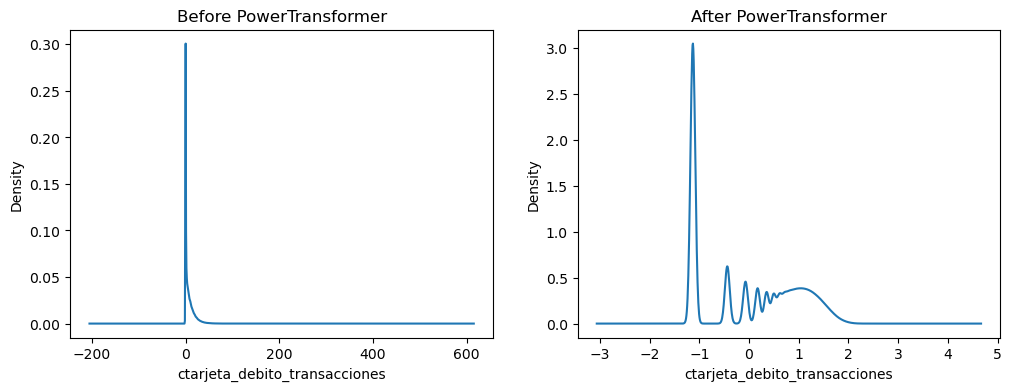

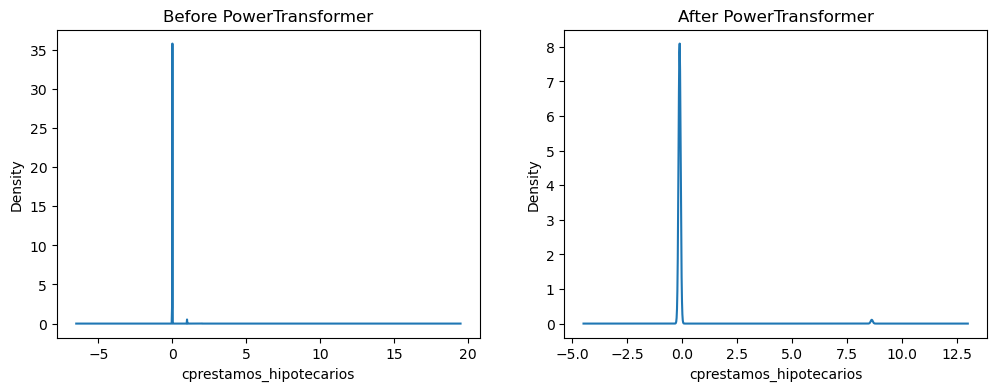

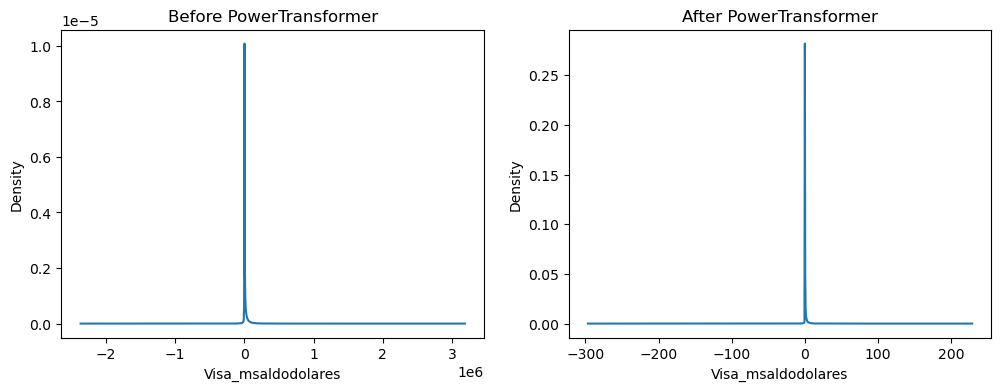

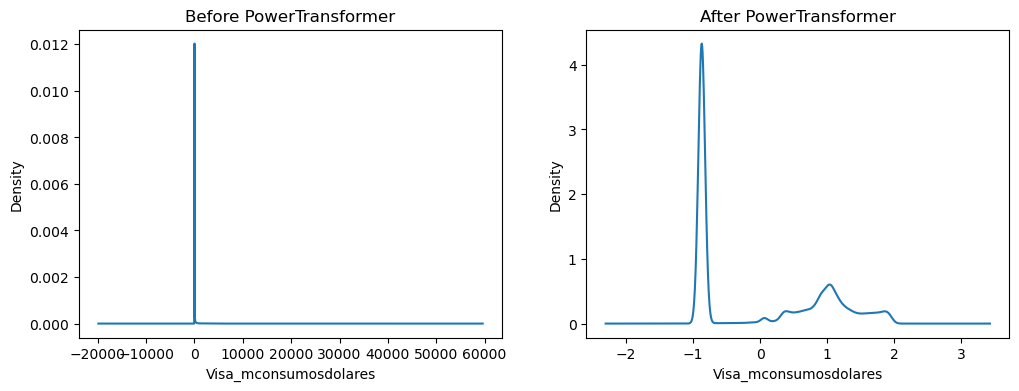

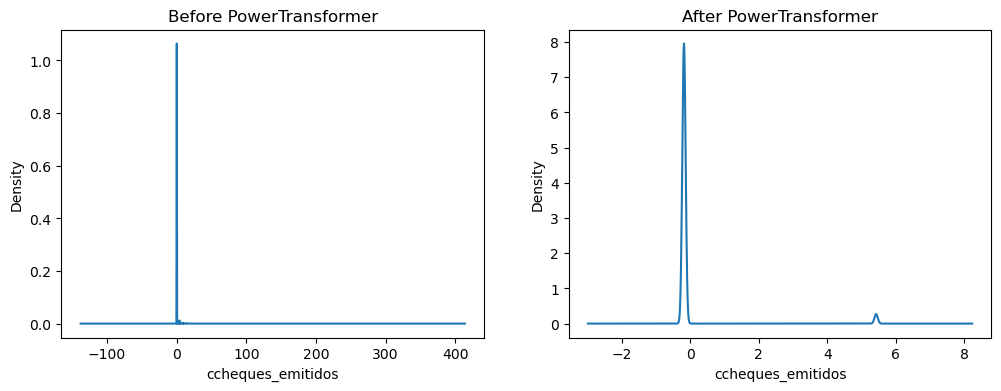

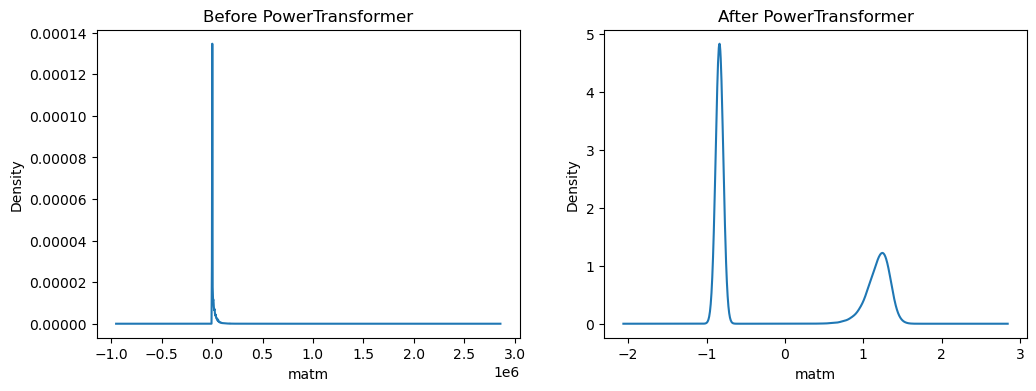

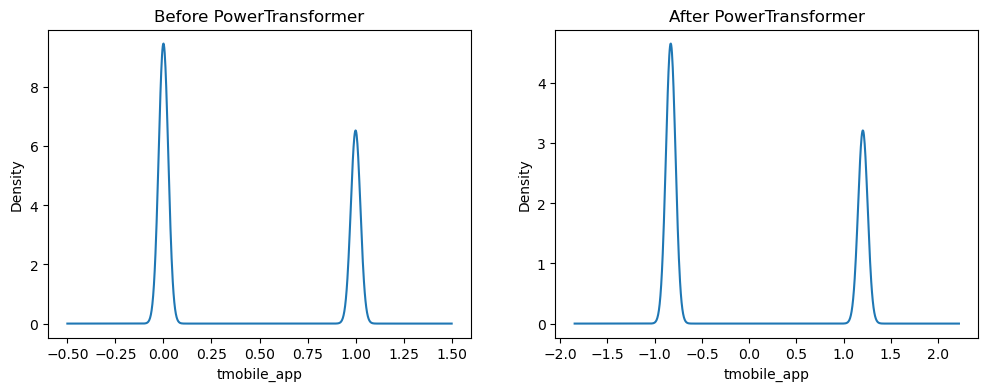

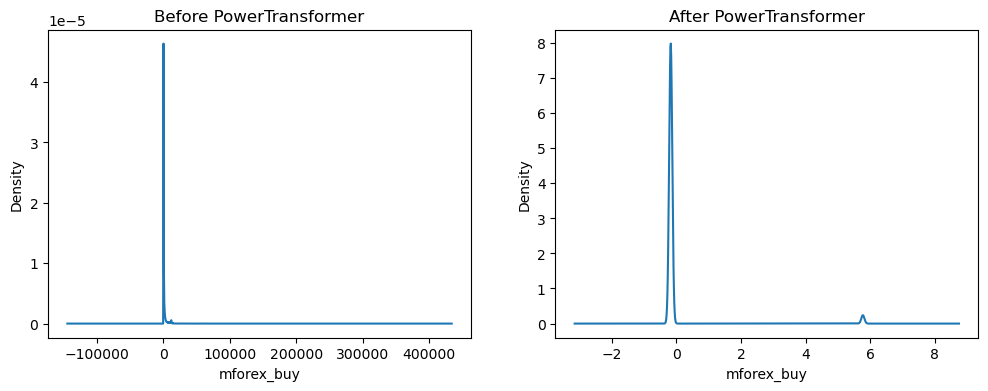

In [112]:
X_train_no_normales = X_train[variables_no_normales_filtradas]

for x in X_train_no_normales.columns:
    plots(X_train_no_normales, x)

In [62]:
X_train[variables_no_normales].describe()

,ccuenta_corriente,cinversion1,mplazo_fijo_pesos,cprestamos_hipotecarios,cliente_vip,mcaja_ahorro_adicional,mcuenta_corriente_adicional,ccajeros_propios_descuentos,minversion1_pesos,ctarjeta_visa_descuentos,...,catm_trx,matm,catm_trx_other,matm_other,mcajeros_propios_descuentos,cseguro_auto,minversion2,cinversion2,minversion1_dolares,mforex_buy
count,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,...,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06,3.747725e+06
mean,1.002998e+00,5.464062e-02,4.777622e+03,1.558812e-02,4.932592e-03,7.756768e+02,4.523333e+01,7.016977e-02,1.306011e+04,9.879007e-02,...,1.882114e+00,1.185684e+04,8.295280e-01,2.854448e+03,1.577773e+01,2.458105e-02,4.578559e+04,1.094699e-01,5.626802e+03,3.607262e+01
std,5.549370e-02,3.652603e-01,1.901205e+05,1.586582e-01,7.005900e-02,1.652263e+04,1.185173e+04,5.198459e-01,2.492910e+05,5.134600e-01,...,3.628397e+00,3.205140e+04,2.176639e+00,8.521990e+03,1.520399e+02,1.707762e-01,1.629230e+06,9.345229e-01,1.938767e+05,7.147650e+02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.107922e+04,-1.990016e+06,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.299000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.000000e+00,1.173000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,4.000000e+00,3.000000e+01,4.860642e+07,1.300000e+01,1.000000e+00,5.796680e+06,1.293837e+07,4.300000e+01,5.320487e+07,3.300000e+01,...,3.400000e+02,1.906125e+06,9.300000e+01,1.446904e+06,3.372609e+04,6.000000e+00,5.136040e+08,6.800000e+01,4.884538e+07,2.893404e+05


<Axes: xlabel='cforex', ylabel='Count'>

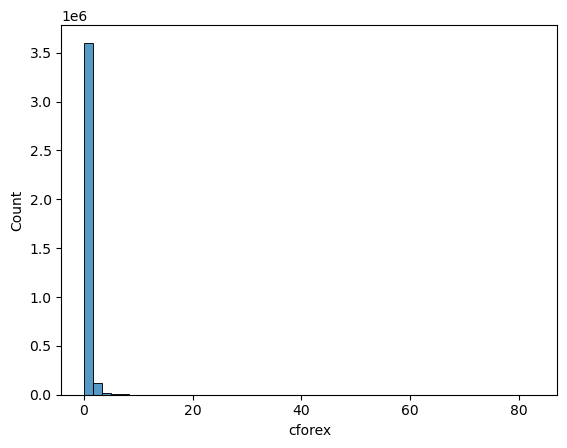

In [63]:
sns.histplot(X_train['cforex'], bins=50)

In [64]:
from sklearn.preprocessing import PowerTransformer

from sklearn.preprocessing import PowerTransformer

for variable in variables_no_normales:

    pt = PowerTransformer(method='yeo-johnson')
    X_train[variable] = pt.fit_transform(X_train[[variable]]+1)
    
    X_test[variable] = pt.transform(X_test[[variable]]+1)

<Axes: xlabel='cforex', ylabel='Count'>

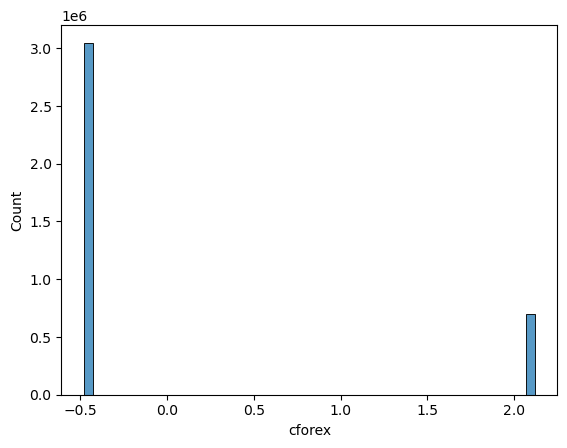

In [65]:
sns.histplot(X_train['cforex'], bins=50)

In [66]:

train_data_post = lgb.Dataset(X_train,
                          label= Y_train,
                          weight=w_train)

model_default_post = lgb.train({}, train_data_post)


test_data_post = lgb.Dataset(X_test,
                          label= Y_test,
                          weight=w_data_test)

y_pred_default_post = model_default_post.predict(X_test)



lgb_gan_eval(y_pred_default_post, test_data_post)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.457872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21098
[LightGBM] [Info] Number of data points in the train set: 3747725, number of used features: 154
[LightGBM] [Info] Start training from score 0.167520


('gan_eval', 139062000, True)

In [ ]:
138628000

In [67]:
explainer_post = shap.TreeExplainer(model_default_post)
shap_values_post = explainer_post.shap_values(X_train)

In [68]:
shap_df_post = pd.DataFrame(shap_values_post, columns = X_train.columns)


In [69]:
importancia_shap_post = pd.DataFrame(np.abs(shap_values_post).mean(0), columns = ['valores_shap'])
importancia_shap_post['variables'] = X_train.columns
importancia_shap_post = importancia_shap_post.sort_values(by = 'valores_shap', ascending = False)

In [70]:
df_trazas_shap_post = importancia_shap_post[importancia_shap_post['valores_shap'] == 0]

In [71]:
lista_post = df_trazas_shap_post['variables'].to_list()
lista_post



['Master_mpagado',
 'Visa_cadelantosefectivo',
 'Visa_mconsumototal',
 'Master_mpagosdolares',
 'cliente_vip',
 'Master_madelantodolares',
 'Visa_mpagado',
 'Visa_mpagosdolares',
 'ccuenta_corriente',
 'Master_mconsumototal',
 'mplazo_fijo_pesos',
 'Master_cadelantosefectivo',
 'mcuenta_corriente_adicional',
 'Visa_madelantodolares',
 'Visa_madelantopesos',
 'mcaja_ahorro_adicional',
 'Master_madelantopesos',
 'cpagodeservicios',
 'Master_mconsumosdolares',
 'ccheques_depositados_rechazados',
 'cpagomiscuentas',
 'mttarjeta_master_debitos_automaticos',
 'ccajeros_propios_descuentos',
 'mcajeros_propios_descuentos',
 'ctarjeta_visa_descuentos',
 'mtarjeta_visa_descuentos',
 'ctarjeta_master_descuentos',
 'mtarjeta_master_descuentos',
 'ctarjeta_master_debitos_automaticos',
 'cforex',
 'cforex_sell',
 'mforex_sell',
 'ccheques_depositados',
 'mcheques_depositados',
 'mcheques_depositados_rechazados',
 'Master_msaldodolares',
 'ccuenta_debitos_automaticos',
 'cpayroll2_trx',
 'mpayroll2',

In [72]:
len(lista)

54

In [73]:
len(lista_post)

51

In [74]:
for x in lista:
    if x in lista_post:
        print(f'La variable {x} se encuentra en ambas listas')
    else:
        print(f'--------La variable {x} no se encuentra en ambas listas')
for x in lista_post:
    if x not in lista:
        print (f'!!!!!!!! La variable {x} no se encuentra en ambas listas y es nueva')

La variable Master_cadelantosefectivo se encuentra en ambas listas
La variable ccuenta_corriente se encuentra en ambas listas
La variable Master_mconsumototal se encuentra en ambas listas
La variable Master_mpagosdolares se encuentra en ambas listas
La variable cinversion1 se encuentra en ambas listas
La variable Master_mpagado se encuentra en ambas listas
La variable mplazo_fijo_pesos se encuentra en ambas listas
--------La variable ctarjeta_debito_transacciones no se encuentra en ambas listas
--------La variable cprestamos_hipotecarios no se encuentra en ambas listas
La variable Visa_cadelantosefectivo se encuentra en ambas listas
La variable Visa_mconsumototal se encuentra en ambas listas
La variable Visa_mpagado se encuentra en ambas listas
La variable cliente_vip se encuentra en ambas listas
--------La variable Visa_msaldodolares no se encuentra en ambas listas
La variable Visa_mpagosdolares se encuentra en ambas listas
--------La variable Visa_mconsumosdolares no se encuentra en 